In [1]:
%matplotlib inline
import os
from pprint import pprint
import shutil
import subprocess
import urllib.request

import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm
from matplotlib.patches import Rectangle

import openmc.data

### ENDF: Resonance Covariance Data

We can also load the resonance covariance data contained within File 32 of ENDF. Let's download the ENDF/B-VII.1 evaluation for $^{157}$Gd and load it in:

In [2]:
# Download ENDF file
url = 'https://t2.lanl.gov/nis/data/data/ENDFB-VII.1-neutron/Gd/157'
filename, headers = urllib.request.urlretrieve(url, 'gd157.endf')

# Load into memory
gd157_endf = openmc.data.IncidentNeutron.from_endf(filename, covariance = True)
gd157_endf

<IncidentNeutron: Gd157>

We can access the parameters contained within File 32 in a similar manner to the File 2 parameters from before. 

In [3]:
first_five = gd157_endf.resonance_covariance.ranges[0].parameters[:5]
print(first_five)

    energy    J  neutronWidth  captureWidth  fissionWidthA  fissionWidthB  L
0   0.0314  2.0      0.000474        0.1072            0.0            0.0  0
1   2.8250  2.0      0.000345        0.0970            0.0            0.0  0
2  16.2400  1.0      0.000400        0.0910            0.0            0.0  0
3  16.7700  2.0      0.012800        0.0805            0.0            0.0  0
4  20.5600  2.0      0.011360        0.0880            0.0            0.0  0


The newly created object will contain multiple resonance regions within 'gd157_endf.res_covariance.ranges'. We can access the full covariance matrix from File 32 for a given range by:

In [4]:
covariance = gd157_endf.resonance_covariance.ranges[0].covariance

This covariance matrix currently only stores the upper triangular portion as covariance matrices are symmetric. Plotting the covariance matrix:

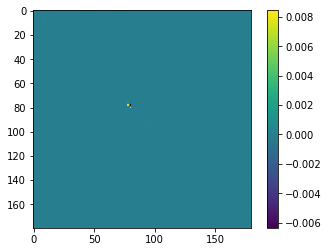

In [5]:
plt.imshow(covariance)
plt.colorbar()

Another capability of the covariance module is selecting a subset of the resonance parameters and the corresponding subset of the covariance matrix. We can do this by specifying the value we want to discriminate and the bounds within one energy region. Selecting only resonances with J=2:

In [6]:
lower_bound = 2; #inclusive
upper_bound = 2; #inclusive
gd157_endf.resonance_covariance.ranges[0].res_subset('J',[lower_bound,upper_bound])
subset_first_five = gd157_endf.resonance_covariance.ranges[0].parameters_subset[:5]
print(subset_first_five)

    energy    J  neutronWidth  captureWidth  fissionWidthA  fissionWidthB  L
0   0.0314  2.0      0.000474        0.1072            0.0            0.0  0
1   2.8250  2.0      0.000345        0.0970            0.0            0.0  0
3  16.7700  2.0      0.012800        0.0805            0.0            0.0  0
4  20.5600  2.0      0.011360        0.0880            0.0            0.0  0
5  21.6500  2.0      0.000376        0.1140            0.0            0.0  0


The subset method will also store the corresponding subset of the covariance matrix

In [7]:
cov_subset = gd157_endf.resonance_covariance.ranges[0].cov_subset
print(cov_subset[:5,:5])

[[  2.82609600e-06   5.89537500e-09  -4.78638600e-06  -5.73895500e-08
   -1.48636900e-09]
 [  0.00000000e+00   1.36218000e-11  -9.61975600e-09  -1.15354000e-10
   -2.87250000e-12]
 [  0.00000000e+00   0.00000000e+00   8.20814700e-06   9.83537100e-08
    2.58111200e-09]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   6.54205000e-06
   -4.31977000e-10]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    1.76975000e-10]]


The covariance module also has the ability to sample a new set of parameters using the covariance matrix. Currently the sampling uses np.multivariate_normal(). Because parameters are assumed to have a multivariate normal distribution this method doesn't not currently guarantee that sampled parameters will be positive.

In [8]:
rm_resonance = gd157_endf.resonances.ranges[0]
n_samples = 5
gd157_endf.resonance_covariance.ranges[0].sample_resonance_parameters(n_samples, rm_resonance)
samples = gd157_endf.resonance_covariance.ranges[0].samples
type(samples[0])


openmc.data.resonance.ReichMoore

The sampling routine requires the incorpotation of the `openmc.data.ResonanceRange` for the same resonance range object. This allows each sample itself to be its own `openmc.data.ResonanceRange` with a new set of parameters. Looking at some of the sampled parameters below:

In [9]:
first_five_sample_1 = samples[0].parameters[:5]
first_five_sample_2 = samples[1].parameters[:5]
print('Sample 1')
print(first_five_sample_1)
print('Sample 2')
print(first_five_sample_2)

Sample 1
      energy  L    J  neutronWidth  captureWidth  fissionWidthA  fissionWidthB
0   0.032307  0  2.0      0.000477      0.105887            0.0            0.0
1   2.827218  0  2.0      0.000349      0.094165            0.0            0.0
2  16.298283  0  1.0      0.000519      0.183407            0.0            0.0
3  16.771312  0  2.0      0.012540      0.078625            0.0            0.0
4  20.558190  0  2.0      0.011813      0.085244            0.0            0.0
Sample 2
      energy  L    J  neutronWidth  captureWidth  fissionWidthA  fissionWidthB
0   0.033027  0  2.0      0.000476      0.104104            0.0            0.0
1   2.825226  0  2.0      0.000344      0.098390            0.0            0.0
2  16.245609  0  1.0      0.000353      0.095063            0.0            0.0
3  16.764396  0  2.0      0.013475      0.075175            0.0            0.0
4  20.560505  0  2.0      0.011994      0.081186            0.0            0.0


We can reconstruct the cross section from the sampled parameters using the reconstruct method of  `openmc.data.ResonanceRange`. For more on reconstruction see the Nuclear Data example notebook. 

In [10]:
gd157_endf.resonances.ranges

Text(0,0.5,'Cross section (b)')

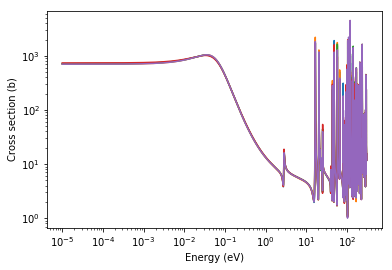

In [11]:
energy_range = [rm_resonance.energy_min, rm_resonance.energy_max]
energies = np.logspace(np.log10(energy_range[0]),
                       np.log10(energy_range[1]), 10000)
for sample in gd157_endf.resonance_covariance.ranges[0].samples:
    xs = sample.reconstruct(energies)
    elastic_xs = xs[2]
    plt.loglog(energies, elastic_xs)
plt.xlabel('Energy (eV)')
plt.ylabel('Cross section (b)')

    